In [1]:
%pylab inline
import dsift
import sys
sys.path.insert(0, "/home/ubuntu/pictureweb/notebooks/")
from pictureweb.distributed import sharded_matrix 
from pictureweb.distributed import distributed as D 
from importlib import reload
reload(sharded_matrix)
import pywren
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture


Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'pyvl'

In [2]:
def fisher_vector(xx, gmm):
    """Computes the Fisher vector on a set of descriptors.

    Parameters
    ----------
    xx: array_like, shape (N, D) or (D, )
        The set of descriptors

    gmm: instance of sklearn mixture.GMM object
        Gauassian mixture model of the descriptors.

    Returns
    -------
    fv: array_like, shape (K + 2 * D * K, )
        Fisher vector (derivatives with respect to the mixing weights, means
        and variances) of the given descriptors.

    Reference
    ---------
    J. Krapac, J. Verbeek, F. Jurie.  Modeling Spatial Layout with Fisher
    Vectors for Image Categorization.  In ICCV, 2011.
    http://hal.inria.fr/docs/00/61/94/03/PDF/final.r1.pdf

    """
    import time
    s = time.time()
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    e = time.time()
    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten())), e - s



In [3]:
%time X_train_sharded = sharded_matrix.ShardedMatrix("imagenet_train_raw_uint8_row_shards", bucket="pictureweb")

CPU times: user 116 ms, sys: 4 ms, total: 120 ms
Wall time: 244 ms


In [35]:
import boto3

In [15]:
X_train_sharded.shape

(1281167, 196608)

In [5]:
%time row_block = D.get_row_block(X_train_sharded, row_blocks=[0], dtype="uint8")

[0]
0
ARGMAX 0
MMAP SHAPE IS  (64, 196608)
CPU times: user 136 ms, sys: 404 ms, total: 540 ms
Wall time: 1.02 s


In [6]:
row_images = row_block.reshape(-1, 3, 256, 256).transpose(0,3,2,1)

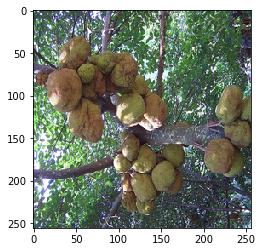

In [7]:
imshow(row_images[0])

In [8]:
reload(dsift)
num_scales = 5

In [13]:
def dense_sift_multiscale(im, num_scales=5):
    im = im.reshape(256, 256, 3)
    sigma_edge = 0.8
    features = []
    positions = []
    for i in range(num_scales):
        sift = dsift.DsiftExtractor(4,24, sigma_edge=(sigma_edge+i))
        result = sift.process_image(im, positionNormalize=False)
        features.append(result[0])
        positions.append(result[1])
    return np.vstack(features)

def pywren_dense_sift_multiscale(sm, block, num_scales=5, sample=0):
    import random
    row_block = sm.get_block(block, 0)
    row_images = row_block.reshape(-1, 3, 256, 256).transpose(0,3,2,1)
    features = []
    for im in row_images:
        sifts = dense_sift_multiscale(im, num_scales)
        num_samples_per_image = max(int(sifts.shape[0]*np.sqrt(sample)), 1)
        
        idxs_sifts = np.random.choice(sifts.shape[0], num_samples_per_image, replace=False)
        features.append(sifts[idxs_sifts])
    features = np.vstack(features)
    num_samples_per_batch = int(features.shape[0]*np.sqrt(sample))
    idxs = np.random.choice(features.shape[0], num_samples_per_batch, replace=False)
    return features[idxs]

def fisher_vector_sift(gmm, im, num_scales=5):
    sifts = dense_sift_multiscale(im, num_scales=num_scales)
    fv = fisher_vector(sifts, gmm)[0]
    return fv

def pywren_fisher_vector_sift(sm, gmm, block, num_scales=5):
    row_block = sm.get_block(block, 0)
    row_images = row_block.reshape(-1, 3, 256, 256).transpose(0,3,2,1)
    features = []
    for im in row_images:
        features.append(fisher_vector_sift(gmm, im, num_scales=num_scales))
    return np.vstack(features)

In [16]:
%time fisher_vector_sift(gmm, row_images[0])

Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
CPU times: user 3.22 s, sys: 172 ms, total: 3.39 s
Wall time: 1.98 s


array([  1.62874704e-03,  -2.39517779e-02,  -4.64062407e-03, ...,
         2.77461545e-05,  -6.99362135e-06,  -3.15069185e-05])

In [17]:
pwex = pywren.default_executor(job_max_runtime=2000)

In [37]:
sorted(X_train_sharded._block_idxs(0)) == X_train_sharded._block_idxs(0)

True

In [28]:
%time feature_futures = pwex.map(lambda x: pywren_fisher_vector_sift(X_train_sharded, gmm, x), X_train_sharded._block_idxs(0), exclude_modules=["site-packages"])



CPU times: user 8min 34s, sys: 25.2 s, total: 8min 59s
Wall time: 3min 5s


In [29]:
%time pywren.wait(feature_futures)

CPU times: user 41min 37s, sys: 3min 23s, total: 45min 1s
Wall time: 27min 20s


([<pywren.future.ResponseFuture at 0x7faed845ef60>,
  ...],
 [])

In [30]:
features = np.vstack([f.result() for f in feature_futures])

In [33]:
%time XTX = features.T.dot(features)

CPU times: user 21min 9s, sys: 0 ns, total: 21min 9s
Wall time: 49.1 s


In [34]:
XTX

array([[  4.45154479e+02,  -3.44541838e+02,   4.20266074e+01, ...,
         -9.29577052e-02,  -3.56183530e-01,  -3.91153535e-01],
       [ -3.44541838e+02,   2.90645346e+03,  -2.64478581e+02, ...,
         -3.36087374e-01,   7.66682010e-01,   1.00876545e+00],
       [  4.20266074e+01,  -2.64478581e+02,   3.86710191e+02, ...,
         -1.27653329e-01,  -2.85495995e-01,  -3.32583768e-01],
       ..., 
       [ -9.29577052e-02,  -3.36087374e-01,  -1.27653329e-01, ...,
          2.90655973e-02,   1.80524526e-02,   8.80422563e-03],
       [ -3.56183530e-01,   7.66682010e-01,  -2.85495995e-01, ...,
          1.80524526e-02,   1.70111723e-02,   1.35946282e-02],
       [ -3.91153535e-01,   1.00876545e+00,  -3.32583768e-01, ...,
          8.80422563e-03,   1.35946282e-02,   1.84163342e-02]])

In [38]:
y_train = np.load("scrambled_train_labels.npy")

In [40]:
y_train_enc = np.eye(1000)[y_train.astype('int').ravel()]

In [43]:
%time XTy = features.T.dot(y_train_enc)

CPU times: user 9min 18s, sys: 3min 3s, total: 12min 22s
Wall time: 23.8 s


In [48]:
np.save("features_fv", features)

In [47]:
XTX.dtype

dtype('float64')

In [46]:
%time scipy.linalg.solve(XTX, XTy)

KeyboardInterrupt: 

In [93]:
help(pywren.default_executor)

Help on function default_executor in module pywren.wren:

default_executor(**kwargs)



In [98]:
%time futures = pwex.map(lambda x: pywren_dense_sift_multiscale(X_train_sharded, x, sample=5e-5), X_train_sharded._block_idxs(0), exclude_modules=["site-packages"])

CPU times: user 8min 49s, sys: 31.6 s, total: 9min 21s
Wall time: 3min 22s


In [ ]:
import time
s = time.time()
%time pywren.wait(futures)
e = time.time()
tot = e - s
print("took {0}".format(tot))

In [101]:
tot

1353.2402279376984

In [102]:
words = np.vstack([f.result() for f in futures])

In [103]:
words.shape

(1101003, 128)

In [110]:
words_image_0 = dense_sift_multiscale(row_images[:1])

Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481


In [57]:
256/4096

16.0

In [104]:
%time gmm = GaussianMixture(n_components=16, covariance_type='diag', verbose=3, init_params="kmeans", max_iter=200)
%time gmm.fit(words)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 52.7 µs
Initialization 0
  Iteration 0	 time lapse 75.96546s	 ll change inf
  Iteration 10	 time lapse 29.05130s	 ll change 0.75595
  Iteration 20	 time lapse 28.86260s	 ll change 0.16774
  Iteration 30	 time lapse 28.11720s	 ll change 0.11935
  Iteration 40	 time lapse 28.29290s	 ll change 0.05682
  Iteration 50	 time lapse 27.85616s	 ll change 0.02121
  Iteration 60	 time lapse 27.78878s	 ll change 0.01390
  Iteration 70	 time lapse 28.27190s	 ll change 0.01198
  Iteration 80	 time lapse 28.12029s	 ll change 0.03602
  Iteration 90	 time lapse 28.16355s	 ll change 0.01980
  Iteration 100	 time lapse 28.08916s	 ll change 0.01111
  Iteration 110	 time lapse 27.49411s	 ll change 0.00456
  Iteration 120	 time lapse 27.86015s	 ll change 0.00363
  Iteration 130	 time lapse 27.65707s	 ll change 0.00131
  Iteration 140	 time lapse 27.56081s	 ll change 0.00106
Initialization converged: True	 time lapse 483.25179s	 ll 219.55726
CPU times: 

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=200,
        means_init=None, n_components=16, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=3,
        verbose_interval=10, warm_start=False, weights_init=None)

In [19]:
import pickle

In [108]:
gmm_bytes = pickle.dumps(gmm)

In [112]:
len(gmm_bytes)

66641

In [109]:
with open("gmm_16_sift_only", "wb") as f:
    f.write(gmm_bytes)

In [11]:
import pickle

In [12]:
with open("gmm_16_sift_only", "rb") as f:
    gmm = pickle.loads(f.read())

In [111]:
pwex = pywren.default_executor()
%time futures = pwex.map(lambda x: fisher_vector(x, gmm), [words_image_0])

CPU times: user 840 ms, sys: 204 ms, total: 1.04 s
Wall time: 3.74 s


In [84]:
futures[0].result()[-1]

0.05605602264404297

In [34]:
%time pywren_dense_sift_multiscale(X_train_sharded, 0)

Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24, nFea 3481
Image: w 256, h 256, gs 4, ps 24

0

In [24]:
futures = pwex.map(dense_sift_multiscale, [row_images[0]], set

In [38]:
futures[0].result()

0

In [35]:
%time futures = pwex.map(lambda x: pywren_dense_sift_multiscale(X_train_sharded, x), [0], exclude_modules=["site-packages"])

CPU times: user 4.76 s, sys: 216 ms, total: 4.97 s
Wall time: 6.01 s


In [112]:
%time futures[0].result()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 30.3 µs


array([[  1.63314369e-03,   5.48666872e-02,   6.13933158e-02,
          1.04597299e-01,   2.53012604e-04,   1.48808252e-02,
          4.73360943e-02,   1.32626936e-01,   3.36702580e-09,
          1.81900561e-03,   4.47788652e-02,   1.73580195e-01,
          3.63696515e-05,   3.09694201e-10,   1.67755606e-03,
          2.69106556e-02,   1.55306405e-03,   6.57031916e-02,
          1.67658729e-01,   9.66960392e-02,   2.85927366e-05,
          3.49888722e-03,   1.35854885e-02,   4.19560110e-03,
          5.63863895e-03,   5.71133385e-03,   3.87698343e-02,
          2.32149332e-02,   1.30420008e-02,   5.86502424e-04,
          6.83636928e-03,   1.46479269e-01,   4.24413427e-04,
          8.51891630e-03,   4.82164081e-02,   1.11320427e-02,
          1.80389169e-02,   2.55536173e-02,   4.23426585e-03,
          7.12161804e-05,   2.49450598e-01,   2.49450598e-01,
          1.17905812e-01,   9.34045572e-03,   2.49450598e-01,
          2.49450598e-01,   1.80055586e-01,   1.74543155e-01,
        

Traceback (most recent call last):
  File "/var/task/wrenhandler.py", line 181, in generic_handler
    s3.meta.client.download_file(func_key[0], func_key[1], func_filename)
  File "/var/runtime/boto3/s3/inject.py", line 126, in download_file
    extra_args=ExtraArgs, callback=Callback)
  File "/var/runtime/boto3/s3/transfer.py", line 299, in download_file
    future.result()
  File "/var/runtime/s3transfer/futures.py", line 73, in result
    return self._coordinator.result()
  File "/var/runtime/s3transfer/futures.py", line 233, in result
    raise self._exception
IOError: [Errno 28] No space left on device



{'exception': '[Errno 28] No space left on device', 'exception_traceback': 'Traceback (most recent call last):\n  File "/var/task/wrenhandler.py", line 181, in generic_handler\n    s3.meta.client.download_file(func_key[0], func_key[1], func_filename)\n  File "/var/runtime/boto3/s3/inject.py", line 126, in download_file\n    extra_args=ExtraArgs, callback=Callback)\n  File "/var/runtime/boto3/s3/transfer.py", line 299, in download_file\n    future.result()\n  File "/var/runtime/s3transfer/futures.py", line 73, in result\n    return self._coordinator.result()\n  File "/var/runtime/s3transfer/futures.py", line 233, in result\n    raise self._exception\nIOError: [Errno 28] No space left on device\n', 'start_time': 1501099205.223582, 'func_key': ['erolf-pywren-987', 'pywren.jobs/7bea36a0-1a6c-4965-91e2-cb28eb584a47/func.json'], 'status_key': ['erolf-pywren-987', 'pywren.jobs/7bea36a0-1a6c-4965-91e2-cb28eb584a47/00000/status.json'], 'output_key': ['erolf-pywren-987', 'pywren.jobs/7bea36a0-1a

Exception: ('[Errno 28] No space left on device', 28, 'No space left on device')

In [22]:
np.vstack(features).ravel().shape

(2227840,)

In [61]:
help(dsift.DsiftExtractor)

Help on class DsiftExtractor in module dsift:

class DsiftExtractor(builtins.object)
 |  The class that does dense sift feature extractor.
 |  Sample Usage:
 |      extractor = DsiftExtractor(gridSpacing,patchSize,[optional params])
 |      feaArr,positions = extractor.process_image(Image)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, gridSpacing, patchSize, nrml_thres=1.0, sigma_edge=0.8, sift_thres=0.2)
 |      gridSpacing: the spacing for sampling dense descriptors
 |      patchSize: the size for each sift patch
 |      nrml_thres: low contrast normalization threshold
 |      sigma_edge: the standard deviation for the gaussian smoothing
 |          before computing the gradient
 |      sift_thres: sift thresholding (0.2 works well based on
 |          Lowe's SIFT paper)
 |  
 |  calculate_sift_grid(self, image, gridH, gridW)
 |      This function calculates the unnormalized sift features
 |      It is called by process_image().
 |  
 |  normalize_sift(self, feaArr)
 |      

In [89]:
np.random.choice(10,3)

array([7, 8, 0])